<a href="https://colab.research.google.com/github/AdityaRadjou/Brain-Tumor-Detection/blob/main/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> MRI-based Brain Tumor Detection using Deep Learning <center>

Aditya Radjou

<h2> 1. Collect data </h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import numpy as np
import random
import os
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [3]:
root_dir = "./drive/MyDrive/data"

classes = {'notumor': 0, 'glioma': 1,'meningioma': 2, 'pituitary': 3}

images = [] #will contain all images
targets = [] #will contains the target of the images

def get_data_by_class(c):
  class_dir = os.path.join(root_dir,c)
  images = []
  for i in os.listdir(class_dir):
    img = cv2.imread(os.path.join(class_dir,i),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    images.append(img)
  return np.array(images)

data = []
for c in classes:
  data.append(get_data_by_class(c))

<h2> 2. Data Pre-processing </h2>

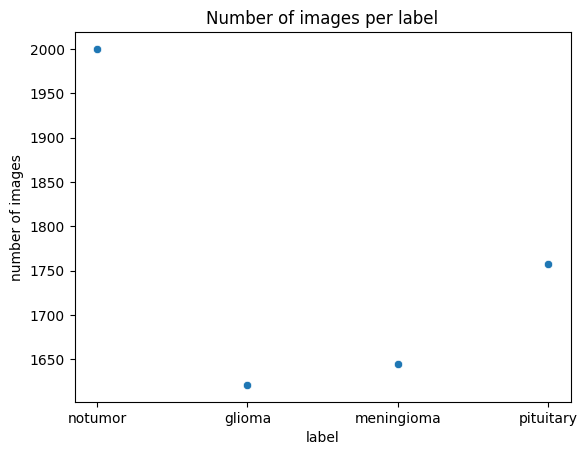

In [45]:
labels = [c for c in classes]
sizes = [len(data[i]) for i in range(4)]

sns.scatterplot(x=labels,y=sizes)
plt.title("Number of images per label")
plt.xlabel("label")
plt.ylabel("number of images")
plt.show()

In [5]:
# Downsampling

n = min(sizes)

images, targets = [],[]
for c in classes:
  images.extend(shuffle(data[classes[c]],n_samples=n))
  targets.extend([classes[c]]*n)

shuffle_indices = np.random.permutation(range(len(images)))
images = np.array(images)[shuffle_indices]
targets = np.array(targets)[shuffle_indices]

#Normalizing

images = images/255

<h2> 3. Training </h2>

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(images,targets,test_size=0.2)

In [7]:
ytrain = tf.keras.utils.to_categorical(ytrain)
ytest = tf.keras.utils.to_categorical(ytest)

In [14]:
mc = ModelCheckpoint(filepath = "bestmodel.h5", monitor="val_accuracy", save_best_only=True)
es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience = 5)

CNN = Sequential()
CNN.add(Conv2D(16,(3,3),activation="relu",input_shape=(128,128,1)))
CNN.add(Conv2D(32,(3,3),activation="relu"))
CNN.add(MaxPooling2D())
CNN.add(Conv2D(64,(3,3),activation="relu"))
CNN.add(MaxPooling2D())
CNN.add(Conv2D(128,(3,3),activation="relu"))
CNN.add(MaxPooling2D())
CNN.add(Dropout(0.25))
CNN.add(Flatten())
CNN.add(Dense(64,activation="relu"))
CNN.add(Dropout(0.25))
CNN.add(Dense(4,activation="sigmoid"))

In [15]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       7

In [16]:
CNN.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [17]:
training = CNN.fit(Xtrain,ytrain,epochs=30,validation_split=0.15, callbacks = [mc,es])

Epoch 1/30
138/138 [==============================] - 20s 41ms/step - loss: 0.7849 - accuracy: 0.6813 - val_loss: 0.5644 - val_accuracy: 0.7741
Epoch 2/30
  3/138 [..............................] - ETA: 4s - loss: 0.6213 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/138 [==============================] - 5s 33ms/step - loss: 0.4583 - accuracy: 0.8253 - val_loss: 0.4668 - val_accuracy: 0.8395
Epoch 3/30
138/138 [==============================] - 4s 31ms/step - loss: 0.3388 - accuracy: 0.8750 - val_loss: 0.3581 - val_accuracy: 0.8780
Epoch 4/30
138/138 [==============================] - 5s 33ms/step - loss: 0.2638 - accuracy: 0.9045 - val_loss: 0.3445 - val_accuracy: 0.8986
Epoch 5/30
138/138 [==============================] - 4s 32ms/step - loss: 0.2042 - accuracy: 0.9263 - val_loss: 0.2672 - val_accuracy: 0.9063
Epoch 6/30
138/138 [==============================] - 4s 31ms/step - loss: 0.1555 - accuracy: 0.9437 - val_loss: 0.2975 - val_accuracy: 0.8960
Epoch 7/30
138/138 [==============================] - 5s 34ms/step - loss: 0.1203 - accuracy: 0.9517 - val_loss: 0.2334 - val_accuracy: 0.9255
Epoch 8/30
138/138 [==============================] - 4s 32ms/step - loss: 0.1179 - accuracy: 0.9574 - val_loss: 0.1980 - val_accuracy: 0.9435
Epoch 9/30

<h2> 4. Testing <h4>

In [53]:
best_CNN = load_model("/content/bestmodel.h5")
acc = best_CNN.evaluate(Xtest,ytest)[1]
print("Accuracy:",acc)

41/41 [==============================] - 1s 11ms/step - loss: 0.2144 - accuracy: 0.9329
Accuracy: 0.9329221248626709


In [50]:
def prediction(label):
  path = os.path.join(os.path.join(root_dir,label),os.listdir(os.path.join(root_dir,label))[random.randint(0,sizes[classes[label]])])
  img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img,(128,128))
  img = np.array(img)/255

  model_prediction = best_CNN.predict(np.expand_dims(img.reshape((128,128,1)),axis=0))
  index_max = np.argmax(model_prediction)
  for key, value in classes.items():
        if value == index_max:
          print("The MRI Scan shows:", label)
          print("The model predicted:", key)

  img_glioma = Image.open(path)
  plt.imshow(img_glioma)
  plt.show()

  return None

1/1 [==============================] - 0s 43ms/step
The MRI Scan shows: meningioma
The model predicted: meningioma


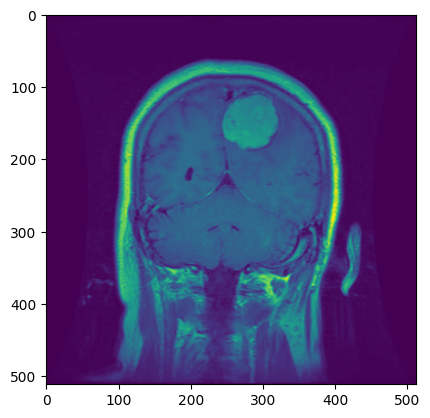

In [52]:
prediction("meningioma")